# Samples analysis
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.2' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
# jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

%matplotlib inline
%load_ext autoreload
%autoreload 2

## What are Chains?
### Chains object is a PyTree made of a data, and optional metadata as groups and labels:
* `data` is a dict of arrays, of arbitrary dimensions.
* `groups` is a dict of list of strings, that serve as alias for fast querying and gathering.
* `labels` is a dict of strings used for plots.

### Chains has classical properties:
* `shape`, `ndim`, `dtype`, `size`...
* Chains can be merged with other Chains, dict, and UserDict using pipe `|`.

### Chains allows variety of keys for easy querying:
* **slicing and indexing**: `chains[3,1::2]` does exactly what you would expect
* **querying values**:

    ```python
    data = {'a':0,'b':1,'c':2}
    groups = {'ab':['a','b']}
    chains = Chains(data, groups)

    # Query by data key or groups
    assert chains['c','ab'] == (2, 0, 1) # 'ab' is an alias for 'a','b'

    # Special keys everything '*', minus '~', and everything minus '*~' 
    assert chains['*~ab'] == 2 # everything minus group 'ab'
    assert chains['*','~c'] == (0, 1) # everything minus 'c'

    # Keys are parsed in given order
    assert chains['~c','*'] == (0, 1, 2) # minus 'c' (empty tuple) plus everything
    ```
* **querying subchains** (as in `panda` but allows non-tabular data):
    ```python
    data = {'a':0,'b':1,'c':2}
    groups = {'ab':['a','b']}
    chains = Chains(data, groups)

    # Query by data key or groups
    ch0, ch1 = chains[['ab'],['c']] # split into subchains
    assert ch0.data == {'a': 0, 'b': 1}

    # Special keys everything '*', minus '~', and everything minus '*~' 
    ch0, ch1 = chains[['*~c'],['c']] # split into subchains
    assert ch1.data == {'c': 2}

    # Mix value and subchain querying
    ch0, v1 = chains[['ab'],'c']
    assert v1 == 2
    ```
### Chains can be transformed:
* chains can be `tree.map`ped
* chains can be stacked by groups, flatten, concatenated...
* chains transforms can themselves be applied on axes splits or cumulatively along axes.
* chains can be plotted, or cast to `getdist`.

## Example 1: assess MCMC convergence

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.mcbench import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2
theme(usetex=True, font_size=12)

# Load a chains file. Typically a NumPyro samples output saved with jnp.savez
# save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc4_obfield/'
save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/m32_b128.0_al1.0_ao1.0_lo1_pc2_obfield_norsdb_lowprior/'
save_path = save_dir + 'sMCLMC_nc4_ns64_mt10_ta0.65'
# model = FieldLevelModel.load(save_dir+'model.p')
model = FieldLevelModel(**default_config | pload(save_dir+'model.p'))

truth = pload(save_dir+'truth.p')
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

transforms = [
              lambda x:x[['*~diverging']],                          # load every variables except diverging boolean
              partial(Chains.thin, thinning=1),                     # thin the chains
              model.reparam_chains,                                 # reparametrize sample variables into base variables
              partial(model.powtranscoh_chains, mesh0=mesh0),       # compute mesh statistics
              partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
              ]
chains = model.load_runs(save_path, 1, 11, transforms=transforms, batch_ndim=2)
names = ['cosmo','bias','init']
chains.shape

Loading: sMCLMC_nc4_ns64_mt10_ta0.65, from run 1 to run 11 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m32_b128.0_al1.0_ao1.0_lo1_pc2_obfield_norsdb_lowprior/sMCLMC_nc4_ns64_mt10_ta0.65_11.npz does not exist, stopping at run 10
No fiducial spectral power mesh stored. Will use linear spectral power mesh computed at location of cosmology prior.


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (4, 640),
 'b1': (4, 640),
 'init_mesh': (4, 640, 10),
 'kptc': ((4, 640, 7), (4, 640, 7), (4, 640, 7), (4, 640, 7)),
 'n_evals': (4, 640),
 'sigma8': (4, 640)}

### We look for mixed chains (no visible trends), `n_eff`>>100, `r_hat`<1.01


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     n_evals    256.00      0.00    256.00    256.00    256.00       nan       nan
     Omega_m      0.24      0.05      0.24      0.16      0.32    466.60      1.01
      sigma8      0.83      0.05      0.83      0.75      0.91    557.99      1.01
init_mesh[0]     -0.38      1.63     -0.43     -3.07      2.28   2533.79      1.00
init_mesh[1]     -0.38      1.55     -0.41     -3.01      2.07   2679.87      1.00
init_mesh[2]      0.09      1.46      0.09     -2.11      2.57   3155.81      1.00
init_mesh[3]     -0.04      1.54     -0.05     -2.75      2.27   2925.79      1.00
init_mesh[4]     -0.25      1.45     -0.26     -2.53      2.15   3188.85      1.00
init_mesh[5]     -0.08      1.57     -0.11     -2.69      2.40   2609.00      1.00
init_mesh[6]     -0.21      1.57     -0.22     -2.75      2.40   2902.69      1.00
init_mesh[7]     -0.27      1.57     -0.27     -2.80      2.36   2752.02      1.00
ini

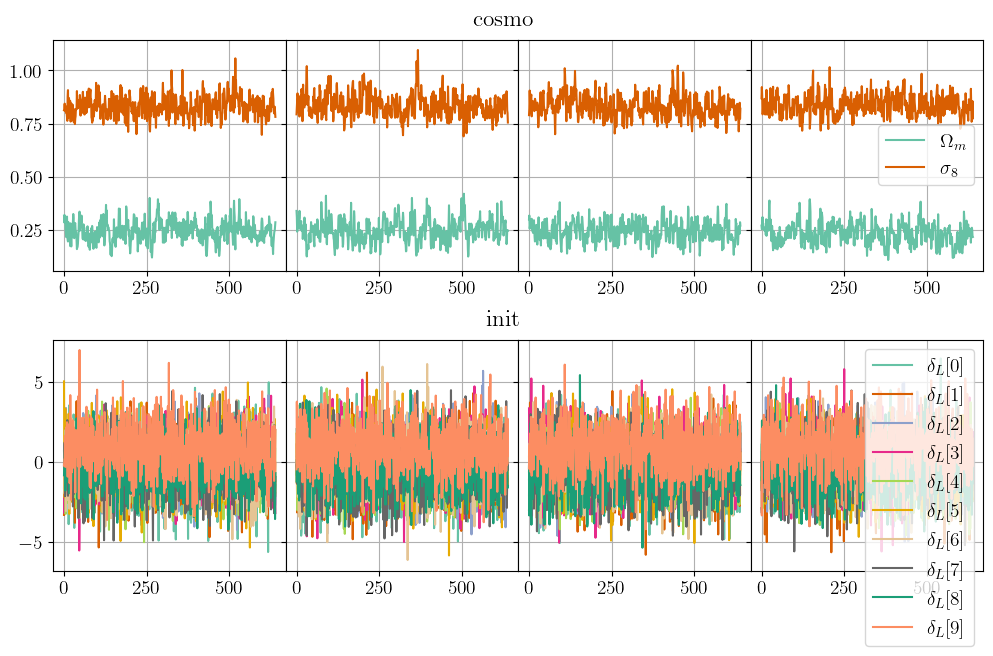

In [91]:
plt.figure(figsize=(12,6))
chains[['*~kptc']].flatten().plot(names, batch_ndim=2)
chains[['*~kptc']].print_summary()

Removed no burn in


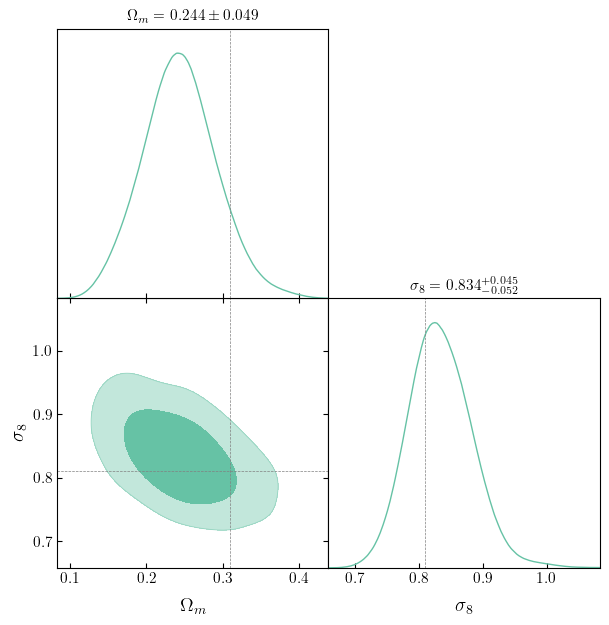

In [92]:
# gdsamp = chains[['cosmo','bias']].to_getdist()
gdsamp = chains[['cosmo']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)])

### Power spectrum should converge close to the truth, and coherence must be on the order of the coherence between truth and obs

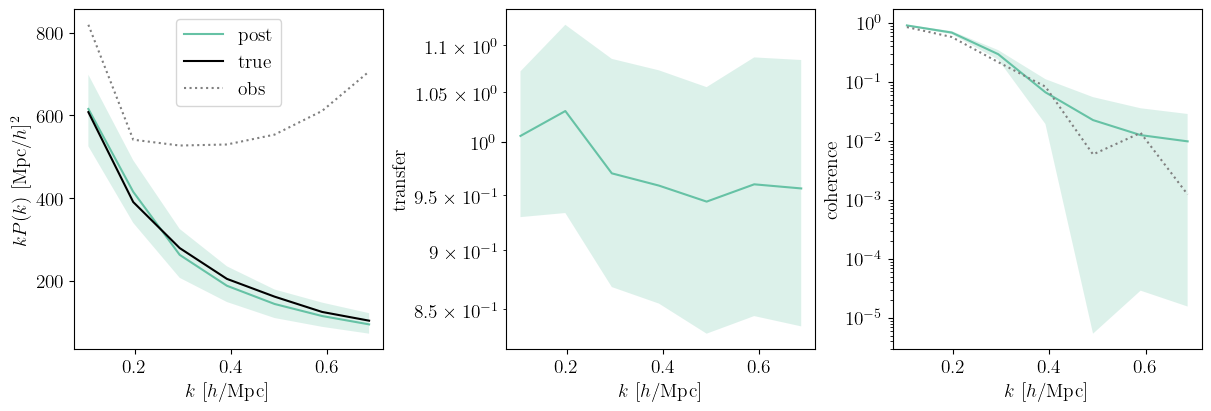

In [93]:
prob = 0.95
log = False

plt.figure(figsize=(12, 4), layout="constrained")
kptcs = tree.map(jnp.concatenate, chains['kptc'])
plot_powtranscoh(*jnp.median(jnp.stack(kptcs), 1), log=log, label='post')
plot_powtranscoh(*kptcs, log=log, fill=prob)

plt.subplot(131)
plot_pow(*pow0, 'k', log=log, label='true')
plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
plt.legend()

plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')

# Example 2: quantify MCMC performance

### Number of eval per effective sample should converge. If so, that's a relevant metric.

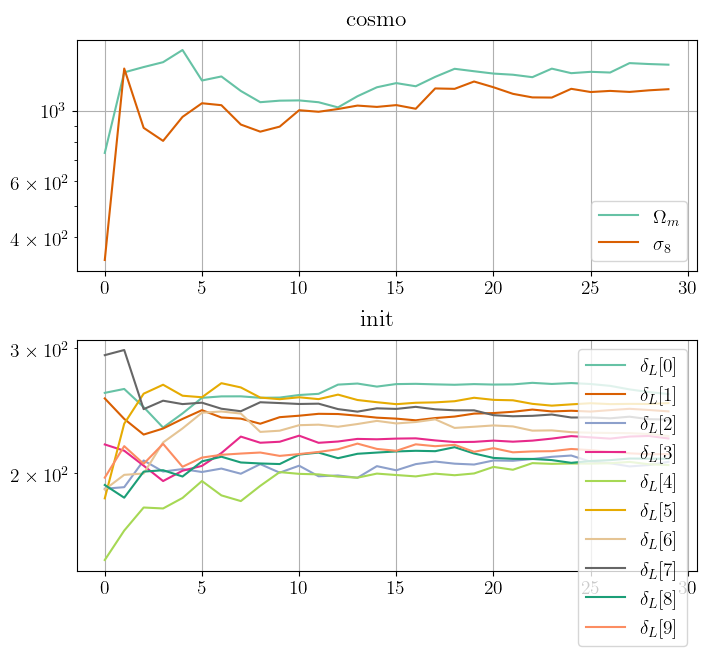

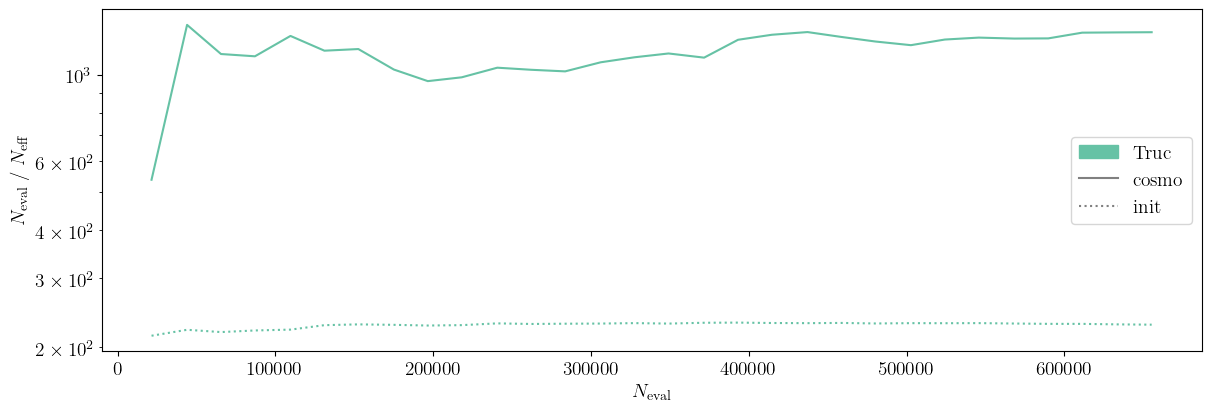

In [94]:
plt.figure(figsize=(8, 6))
chains[['*~kptc']].flatten().cumtrans(Chains.eval_per_ess, 30).plot(names, log=True)

metrics = []
cumess = chains[['*~kptc']].stackby(names).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn():
    plt.figure(figsize=(12, 4), layout="constrained")
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, names)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(names):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");